<a href="https://colab.research.google.com/github/rfr27/QA-Inicio/blob/haystack-antiguo/Qa_ini_v0_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements(is_chapter7=True)

Cloning into 'notebooks'...
remote: Enumerating objects: 515, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 515 (delta 139), reused 127 (delta 123), pack-reused 353
Receiving objects: 100% (515/515), 28.61 MiB | 21.93 MiB/s, done.
Resolving deltas: 100% (246/246), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [2]:
#hide
from utils import *
setup_chapter()

Using transformers v4.6.1
Using datasets v1.11.0


In [3]:
#hide
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [4]:
#hide
# Suppress Haystack logging
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
              "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base", 
              "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

# Question Answering

<img alt="Marie Curie" width="500" caption="A Google search query and corresponding answer snippet" src="images/chapter07_marie-curie.png" id="marie-curie"/>

## Building a Review-Based QA System

### The Dataset

<img alt="Phone with Query" width="400" caption="A question about a product and the corresponding review (the answer span is underlined)" src="images/chapter07_phone.png" id="phone"/>

In [5]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

Downloading:   0%|          | 0.00/2.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [6]:
#hide_output
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset subjqa downloaded and prepared to /root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd. Subsequent calls will reuse this data.


In [7]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ
adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1],
'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective':
[True, True]}


In [8]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [9]:
#hide_output
qa_cols = ["title", "question", "answers.text", 
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [10]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

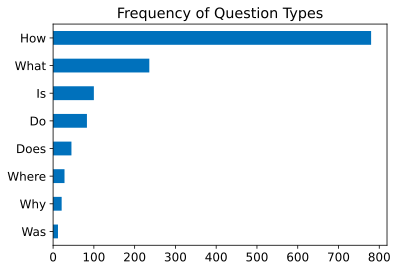

In [11]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [12]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


### Sidebar: The Stanford Question Answering Dataset

<img alt="SQuAD SotA" width="600" caption="Progress on the SQuAD 2.0 benchmark (image from Papers with Code)" src="images/chapter07_squad-sota.png" id="squad-sota"/>

### End sidebar

### Extracting Answers from Text

#### Span classification

<img alt="QA Head" caption="The span classification head for QA tasks" src="images/chapter07_qa-head.png" id="qa-head"/>

<img alt="SQuAD models" width="600" caption="A selection of extractive QA models on the Hugging Face Hub" src="images/chapter07_squad-models.png" id="squad-models"/> 

#### Tokenizing text for QA

In [13]:
#hide_output
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/477 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107 [00:00<?, ?B/s]

In [14]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [15]:
#hide_input
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [16]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so
about 6000 hours depending on file size. [SEP]


In [17]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Downloading:   0%|          | 0.00/133M [00:00<?, ?B/s]

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750,
-5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623,
-5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None,
attentions=None)


In [18]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [19]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


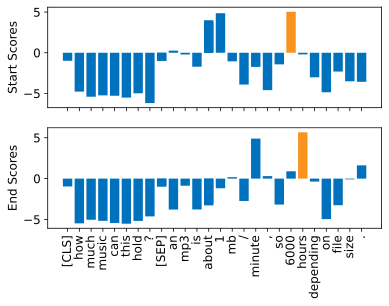

In [20]:
#hide_input
#id qa-scores
#caption Predicted logits for the start and end tokens; the token with the highest score is colored in orange

# The idea for this visualisation comes from https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

In [21]:
import torch 

start_idx = torch.argmax(start_logits)  
end_idx = torch.argmax(end_logits) + 1  
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [22]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

[{'score': 0.26516255736351013,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.2208293378353119,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253478586673737,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [23]:
pipe(question="Why is there no data?", context=context, 
     handle_impossible_answer=True)

{'score': 0.9068408012390137, 'start': 0, 'end': 0, 'answer': ''}

#### Dealing with long passages

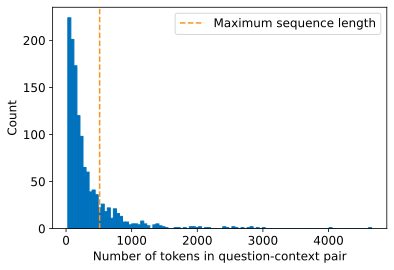

In [24]:
#hide_input
#id subjqa-dist
#caption Distribution of tokens for each question-context pair in the SubjQA training set
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1", 
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

<img alt="Sliding window" caption="How the sliding window creates multiple question-context pairs for long documents—the first bar corresponds to the question, while the second bar is the context captured in each window" src="images/chapter07_sliding-window.png" id="sliding-window"/>

In [25]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], 
                              return_overflowing_tokens=True, max_length=100, 
                              stride=25)

In [26]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [27]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and
qz - 99. the koss portapro is portable and has great bass response. the work
great with my android phone and can be " rolled up " to be carried in my
motorcycle jacket or computer bag without getting crunched. they are very light
and don't feel heavy or bear down on your ears even after listening to music
with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even
after listening to music with them on all day. the sound is night and day better
than any ear - bud could be and are almost as good as the pro 4aa. they are "
open air " headphones so you cannot match the bass to the sealed types, but it
comes close. for $ 32, you cannot go wrong. [SEP]



### Using Haystack to Build a QA Pipeline

<img alt="QA Architecture" caption="The retriever-reader architecture for modern QA systems" src="images/chapter07_retriever-reader.png" id="retriever-reader"/>

#### Initializing a document store

In [28]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [29]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

In [32]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "ae31e791d361",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "A2urx6GpT_mqbxHn8OW13Q",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [33]:
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever 
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [34]:
#hide
# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

In [35]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"text": row["context"], 
             "meta":{"item_id": row["title"], "question_id": row["id"], 
                     "split": split}} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


#### Initializing a retriever

In [36]:
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)

In [37]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [38]:
print(retrieved_docs[0])

{'text': 'This is a gift to myself.  I have been a kindle user for 4 years and
this is my third one.  I never thought I would want a fire for I mainly use it
for book reading.  I decided to try the fire for when I travel I take my laptop,
my phone and my iPod classic.  I love my iPod but watching movies on the plane
with it can be challenging because it is so small. Laptops battery life is not
as good as the Kindle.  So the Fire combines for me what I needed all three to
do. So far so good.', 'score': 6.243799, 'probability': 0.6857824513476455,
'question': None, 'meta': {'item_id': 'B0074BW614', 'question_id':
'868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'embedding': None, 'id':
'252e83e25d52df7311d597dc89eef9f6'}


#### Initializing a reader

In [39]:
#hide_output
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer =True)

INFO:farm.utils:Using device: CUDA 
INFO:farm.utils:Number of GPUs: 1
INFO:farm.utils:Distributed Training: False
INFO:farm.utils:Automatic Mixed Precision: None
Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:farm.utils:Using device: CUDA 
INFO:farm.utils:Number of GPUs: 1
INFO:farm.utils:Distributed Training: False
INFO:farm.utils:Automatic Mixed Precision: None
INFO:farm.infer:Got ya 2 parallel workers to do inference ...
INFO:fa

In [40]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.64808464050293,
'answers': [{'answer': '6000 hours', 'score': 10.699621200561523, 'probability':
0.39881402254104614, 'context': 'An MP3 is about 1 MB/minute, so about 6000
hours depending on file size.', 'offset_start': 38, 'offset_end': 48,
'offset_start_in_doc': 38, 'offset_end_in_doc': 48, 'document_id':
'e344757014e804eff50faa3ecf1c9c75'}]}


#### Putting it all together

In [41]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

In [42]:
n_answers = 3
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers,
                 filters={"item_id": [item_id], "split":["train"]})

print(f"Question: {preds['query']} \n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx]['answer']}")
    print(f"Review snippet: ...{preds['answers'][idx]['context']}...")
    print("\n\n")

Question: Is it good for reading?

Answer 1: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I
mainly use it for book reading.  I decided to try the fire for when I travel I
take my la...



Answer 2: the larger screen compared to the Kindle makes for easier reading
Review snippet: ...ght enough that I can hold it to read, but the larger screen
compared to the Kindle makes for easier reading. I love the color, something I
never thou...



Answer 3: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great
for reading books when no light is available. Amazing sound but I suggest good
headphones t...





## Improving Our QA Pipeline

### Evaluating the Retriever

In [43]:
from haystack.pipeline import Pipeline
from haystack.eval import EvalDocuments

class EvalRetrieverPipeline:
    def __init__(self, retriever):
        self.retriever = retriever
        self.eval_retriever = EvalDocuments()
        pipe = Pipeline()
        pipe.add_node(component=self.retriever, name="ESRetriever", 
                      inputs=["Query"])
        pipe.add_node(component=self.eval_retriever, name="EvalRetriever", 
                      inputs=["ESRetriever"])
        self.pipeline = pipe


pipe = EvalRetrieverPipeline(es_retriever)

In [44]:
from haystack import Label

labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                question=row["question"], answer=answer, id=i, origin=row["id"],
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False)
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            question=row["question"], answer="", id=i, origin=row["id"],
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True)  
        labels.append(label)

In [45]:
print(labels[0])

{'id': '4920ce08-042f-4ad8-a056-5beff20b6386', 'created_at': None, 'updated_at':
None, 'question': 'What is the tonal balance of these headphones?', 'answer': 'I
have been a headphone fanatic for thirty years', 'is_correct_answer': True,
'is_correct_document': True, 'origin': 'd0781d13200014aa25860e44da9d5ea7',
'document_id': None, 'offset_start_in_doc': None, 'no_answer': False,
'model_id': None, 'meta': {'item_id': 'B00001WRSJ', 'question_id':
'd0781d13200014aa25860e44da9d5ea7'}}


In [46]:
document_store.write_labels(labels, index="label")
print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 358 question-answer pairs


In [47]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


In [48]:
print(labels_agg[109])

{'question': 'How does the fan work?', 'multiple_answers': ["the fan itself
isn't super loud. There is an adjustable dial to change fan speed", 'the fan is
really really good'], 'is_correct_answer': True, 'is_correct_document': True,
'origin': 'f20dae56410f31632d6a9f8f8284657a', 'multiple_document_ids': [None,
None], 'multiple_offset_start_in_docs': [None, None], 'no_answer': False,
'model_id': None, 'meta': {'item_id': 'B002MU1ZRS'}}


In [49]:
def run_pipeline(pipeline, top_k_retriever=10, top_k_reader=4):
    for l in labels_agg:
        _ = pipeline.pipeline.run(
            query=l.question,
            top_k_retriever=top_k_retriever,
            top_k_reader=top_k_reader,
            top_k_eval_documents=top_k_retriever,    
            labels=l,
            filters={"item_id": [l.meta["item_id"]], "split": ["test"]})

In [50]:
run_pipeline(pipe, top_k_retriever=3)
print(f"Recall@3: {pipe.eval_retriever.recall:.2f}")

Recall@3: 0.95


In [51]:
#hide_output
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}

    for topk in topk_values:
        # Create Pipeline
        p = EvalRetrieverPipeline(retriever)
        # Loop over each question-answers pair in test set
        run_pipeline(p, top_k_retriever=topk)
        # Get metrics
        topk_results[topk] = {"recall": p.eval_retriever.recall}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")


es_topk_df = evaluate_retriever(es_retriever)

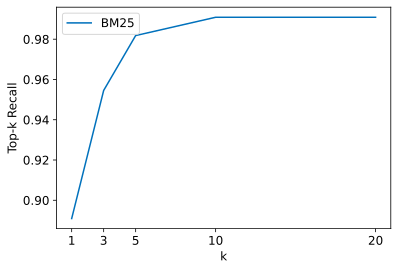

In [52]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
plot_retriever_eval([es_topk_df], ["BM25"])

#### Dense Passage Retrieval

<img alt="DPR Architecture" caption="DPR's bi-encoder architecture for computing the relevance of a document and query" src="images/chapter07_dpr.png" id="dpr"/>

In [53]:
#hide_output
from haystack.retriever.dense import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [54]:
#hide_output
document_store.update_embeddings(retriever=dpr_retriever)

Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

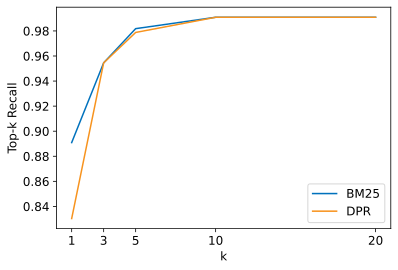

In [55]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([es_topk_df, dpr_topk_df], ["BM25", "DPR"])

### Evaluating the Reader

In [56]:
from farm.evaluation.squad_evaluation import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


In [57]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


In [58]:
from haystack.eval import EvalAnswers

def evaluate_reader(reader):
    score_keys = ['top_1_em', 'top_1_f1']
    eval_reader = EvalAnswers(skip_incorrect_retrieval=False)
    pipe = Pipeline()
    pipe.add_node(component=reader, name="QAReader", inputs=["Query"])
    pipe.add_node(component=eval_reader, name="EvalReader", inputs=["QAReader"])

    for l in labels_agg:
        doc = document_store.query(l.question,
                                   filters={"question_id":[l.origin]})
        _ = pipe.run(query=l.question, documents=doc, labels=l)

    return {k:v for k,v in eval_reader.__dict__.items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

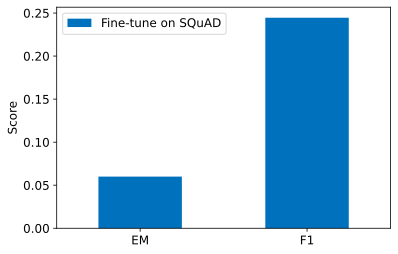

In [59]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

### Domain Adaptation

<img alt="SQuAD Schema" caption="Visualization of the SQuAD JSON format" src="images/chapter07_squad-schema.png" id="squad-schema"/>

In [60]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

In [61]:
#hide_output
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

```python
[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones ...',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass is weak as expected, even with EQ adjusted up',
      'answer_start': 1302}]}],
  'context': 'To anyone who hasn\'t tried all ...'},
 {'qas': [{'question': 'How is the bass?',
    'id': '455575557886d6dfeea5aa19577e5de4',
    'is_impossible': False,
    'answers': [{'text': 'The only fault in the sound is the bass',
      'answer_start': 650}]}],
  'context': "I have had many sub-$100 headphones ..."}]
```

In [62]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)

In [63]:
#hide_output
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

INFO:farm.utils:Using device: CUDA 
INFO:farm.utils:Number of GPUs: 1
INFO:farm.utils:Distributed Training: False
INFO:farm.utils:Automatic Mixed Precision: None
Preprocessing Dataset electronics-train.json:   0%|          | 0/1265 [00:00<?, ? Dicts/s]WARNING:farm.data_handler.processor:Answer using start/end indices is '  Operation of the menus and contro' while gold label text is 'Operation of the menus and controls'.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Preprocessing Dataset electronics-train.json:  20%|██        | 253/1265 [00:02<00:08, 114.60 Dicts/s]
ERROR:farm.data_handler.processor:Unable to convert 2 samples to features. Their ids are : 572-0-0, 595-0-0
Preprocessing Dataset electronics-validation.json:  20%|██        | 51/252 [00:00<00:01, 132.88 Dicts/s]
ERROR:farm.data_handler.processor:Unable to convert 2 samples to features. Their ids are : 572-0-0, 595-0-0
INFO:farm.modeling.optimization:Loading opt

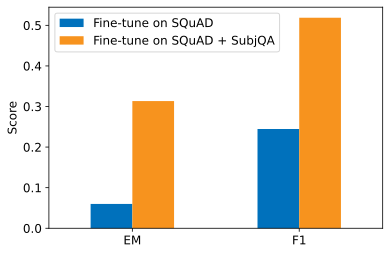

In [64]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

In [65]:
#hide_output
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

INFO:farm.utils:Using device: CUDA 
INFO:farm.utils:Number of GPUs: 1
INFO:farm.utils:Distributed Training: False
INFO:farm.utils:Automatic Mixed Precision: None


Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

INFO:farm.utils:Using device: CUDA 
INFO:farm.utils:Number of GPUs: 1
INFO:farm.utils:Distributed Training: False
INFO:farm.utils:Automatic Mixed Precision: None
INFO:farm.infer:Got ya 2 parallel workers to do inference ...
INFO:farm.infer: 0    0 
INFO:farm.infer:/w\  /w\
INFO:farm.infer:/'\  / \
INFO:farm.infer:  


In [66]:
#hide_output
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

INFO:farm.utils:Using device: CUDA 
INFO:farm.utils:Number of GPUs: 1
INFO:farm.utils:Distributed Training: False
INFO:farm.utils:Automatic Mixed Precision: None
Preprocessing Dataset electronics-train.json:   0%|          | 0/1265 [00:00<?, ? Dicts/s]WARNING:farm.data_handler.processor:Answer using start/end indices is '  Operation of the menus and contro' while gold label text is 'Operation of the menus and controls'.
Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
Preprocessing Dataset electronics-train.json:  20%|██        | 253/1265 [00:02<00:08, 126.21 Dicts/s]
ERROR:farm.data_handler.processor:Unable to convert 2 samples to features. Their ids are : 572-0-0, 595-0-0
Preprocessing Dataset electronics-validation.json:  20%|██        | 51/252 [00:00<00:01, 141.96 Dicts/s]
ERROR:farm.data_handler.processor:Unable to convert 2 samples to features. Their ids are : 572-0-0, 595-0-0
INFO:farm.modeling.optimization:Loading opt

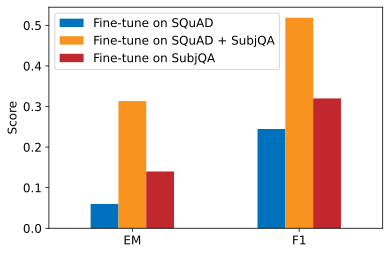

In [67]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)
plot_reader_eval(reader_eval)

### Evaluating the Whole QA Pipeline

In [68]:
#hide_output
# Initialize retriever pipeline
pipe = EvalRetrieverPipeline(es_retriever)
# Add nodes for reader
eval_reader = EvalAnswers()
pipe.pipeline.add_node(component=reader, name="QAReader", 
              inputs=["EvalRetriever"])
pipe.pipeline.add_node(component=eval_reader, name="EvalReader", 
              inputs=["QAReader"])
# Evaluate!
run_pipeline(pipe)
# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in eval_reader.__dict__.items()
    if k in ["top_1_em", "top_1_f1"]}

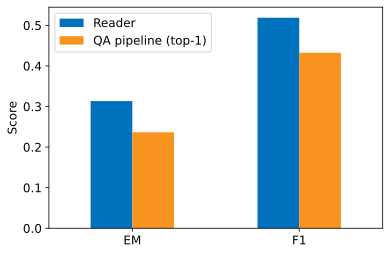

In [69]:
#hide_input
#id reader-vs-pipeline
#caption Comparison of EM and _F_~1~ scores for the reader against the whole QA pipeline
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

## Going Beyond Extractive QA

<img alt="RAG Architecture" width="600" caption="The RAG architecture for fine-tuning a retriever and generator end-to-end (courtesy of Ethan Perez)" src="images/chapter07_rag-architecture.png" id="rag"/>

In [70]:
#hide_output
from haystack.generator.transformers import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

Downloading:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions.The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.06G [00:00<?, ?B/s]

Some weights of RagTokenForGeneration were not initialized from the model checkpoint at facebook/rag-token-nq and are newly initialized: ['rag.generator.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
#hide_output
from haystack.pipeline import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [72]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query, top_k_generator=top_k_generator, 
                     top_k_retriever=5, filters={"item_id":["B0074BW614"]})  
    print(f"Question: {preds['query']} \n")
    for idx in range(top_k_generator):
        print(f"Answer {idx+1}: {preds['answers'][idx]['answer']}")

In [73]:
generate_answers(query)

/usr/local/lib/python3.9/dist-packages/transformers/models/rag/tokenization_rag.py:92: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/generation_utils.py:1712: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(


Question: Is it good for reading?

Answer 1:  the screen is absolutely beautiful
Answer 2:  the Screen is absolutely beautiful
Answer 3:  Kindle fire


In [74]:
generate_answers("What is the main drawback?")

Question: What is the main drawback?

Answer 1:  the price
Answer 2:  no flash support
Answer 3:  the cost


## Conclusion

<img alt="QA Pyramid" caption="The QA hierarchy of needs" src="images/chapter07_qa-pyramid.png" id="qa-pyramid"/> 